# Manually rewriting tket2 circuits

Tket2 includes a rewrite engine based on pattern matching and replacement. This allows for the application of a sequence of rewrite rules to a circuit, which can be used to simplify or optimize the circuit. In this notebook, we will demonstrate how to use this feature to rewrite circuits.

In [1]:
# !uv pip install "tket>=0.12.5,<0.13"
# !uv pip install "guppylang>=0.21,<0.22"

In [2]:
import itertools
import copy

from tket.circuit import Tk2Circuit
from tket.circuit.build import H, from_coms, CX, PauliX, PauliY, PauliZ, id_circ
from tket.pattern import Rule, RuleMatcher
    
from pytket import Circuit as Tk1Circuit
from pytket.circuit.display import render_circuit_jupyter

from guppylang import guppy
from guppylang.module import GuppyModule
from guppylang.std import quantum
from guppylang.std.quantum import qubit, cx, rz#, zz_phase
from guppylang.std.qsystem import zz_phase
from guppylang.std.angles import angle
from guppylang.std.builtins import owned

# We define a utility function to convert a GuppyModule to a Tk2Circuit.
# This will be included with guppy in the future.
from utils import guppy_to_circuit # type: ignore

### Applying simple rewrite rules

In the following example, we will define a couple simplification rules and apply them to a circuit. The rules are:

1. A sequence of `CX` - `Rz` - `CX` gates can be replaced by a single `ZZPhase`
2. A `ZZPhase(0.5)` gate can be replaced with a single `CX` and some single-qubit gates

Let's define these rules first.

In [14]:
# Note: Most of this boilerplate will be removed in the future.

# First we define the pattern we want to match, as a Guppy function
@guppy
def cnots_to_zzphase_lhs(q0: qubit @owned, q1: qubit @owned, angle: angle) -> tuple[qubit, qubit]:
    # cx(q0, q1)
    # rz(q1, angle)
    # cx(q0, q1)
    return (q0, q1)
print(type(cnots_to_zzphase_lhs))
cnots_to_zzphase_lhs = guppy_to_circuit(cnots_to_zzphase_lhs)

# Then we define the replacement circuit
@guppy
def cnots_to_zzphase_rhs(q0: qubit @owned, q1: qubit @owned, angle: angle) -> tuple[qubit, qubit]:
    zz_phase(q0, q1, angle)
    return (q0, q1)
cnots_to_zzphase_rhs = guppy_to_circuit(cnots_to_zzphase_rhs)

cnots_to_zzphase_rhs,cnots_to_zzphase_lhs

<class 'guppylang.defs.GuppyFunctionDefinition'>
0
0


(<Tk2Circuit at 0x11d1ed3c0>, <Tk2Circuit at 0x10c61fe80>)

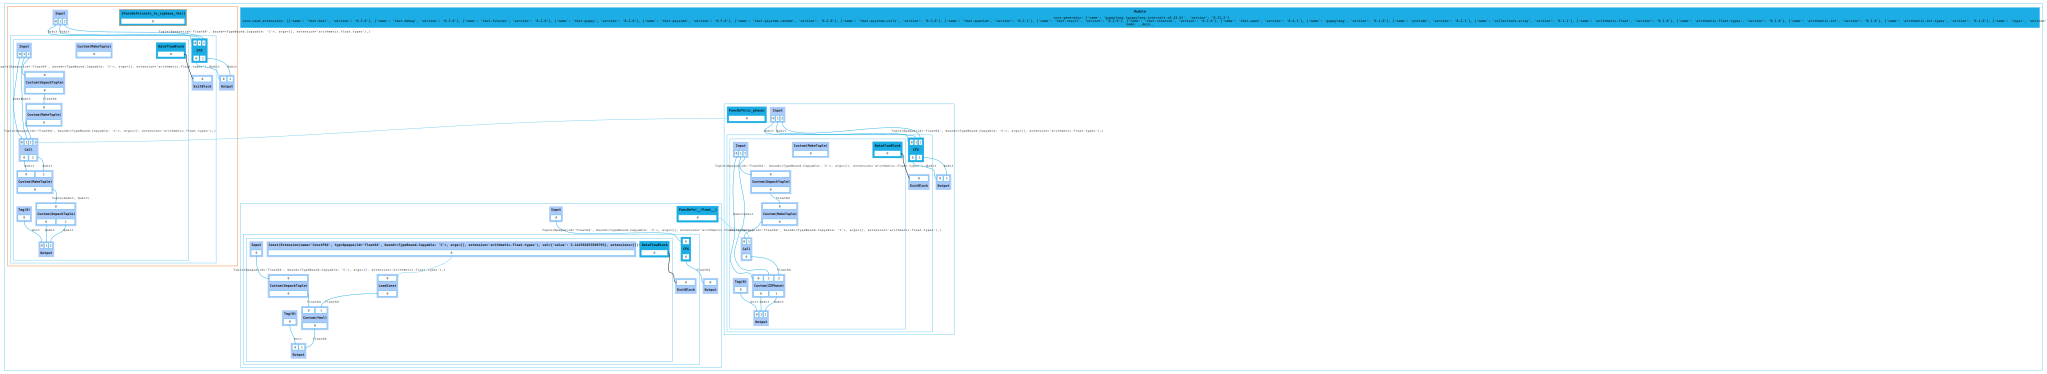

In [17]:
## THIS IS NOT EMPTY...
# from utils import setup_jupyter_rendering # type: ignore
# setup_jupyter_rendering()

cnots_to_zzphase_rhs

In [4]:
#guppy operations aren't being recognised as TketOps -> InvalidPattern because pattern.rs thinks its working with EmptyCircuit
#num_operations returns 0 for both circuits
cnots_to_zzphase_rhs.num_operations()

0

In [5]:
# define the Rule, and create a RuleMatcher with it
cnots_to_zzphase = Rule(l = cnots_to_zzphase_lhs, r = cnots_to_zzphase_rhs)
cnots_to_zzphase

In [6]:
cnots_matcher = RuleMatcher([cnots_to_zzphase])

PyInvalidPatternError: Empty circuits are not allowed as patterns

We can now apply the rules to a circuit.

In [ ]:
original_circ = Tk1Circuit(3).CX(1, 2).Rz(1/4, 2).CX(1, 2).CX(0, 1).Rz(1/2, 1).CX(0, 1)

print("Original circuit:")
render_circuit_jupyter(original_circ)

# Match our rewrite rule once, then apply it.
merged_circ = Tk2Circuit(original_circ)
while rewrite := cnots_matcher.find_match(merged_circ):
    merged_circ.apply_rewrite(rewrite)

print("Rewritten circuit:")
render_circuit_jupyter(merged_circ.to_tket1())

Since the second rewrite rule does not have free parameters, we can define the pattern in pytket.

In [ ]:
# For circuits with no free parameters, we can use pytket directly
zzphase_to_cnot = Rule(
    Tk1Circuit(2).ZZPhase(0.5, 0, 1),
    Tk1Circuit(2).Rx(3.5, 0).Rz(0.5, 1).Rz(1.5, 0).CX(1, 0).Rz(0.5, 0).Rx(0.5, 0).Rz(0.5, 0)
)
zzphase_matcher = RuleMatcher([zzphase_to_cnot])

# Apply the matcher to the previous circuit
final_circ = copy.deepcopy(merged_circ)
while rewrite := zzphase_matcher.find_match(final_circ):
    final_circ.apply_rewrite(rewrite)

print("Rewritten circuit:")
render_circuit_jupyter(final_circ.to_tket1())


The power of `RuleMatcher` gets unlocked when it is defined with multiple rules to apply at once. It can efficiently match millions of rules simultaneously.

### Pauli propagation using rewrite rules

In this example we want to propagate Pauli gates through a circuit, using hand-written rules.

Let's start by defining how Pauli gates propagate through CNOT and Hadamard gates.
For each pair of (pauli, gate) we define a corresponding replacement (gate, pauli).


In [ ]:
# 'from_coms' takes a list of commands and returns a circuit.
# It's a shorthand for using the 'CircBuild' builder to build non-parametric circuits.

hadamard_rules = [
    Rule(from_coms(PauliX(0), H(0)), from_coms(H(0), PauliZ(0))),
    Rule(from_coms(PauliZ(0), H(0)), from_coms(H(0), PauliX(0))),
]

cx_rules = [
    Rule(from_coms(PauliZ(0), CX(0, 1)), from_coms(CX(0, 1), PauliZ(0))),
    Rule(from_coms(PauliX(1), CX(0, 1)), from_coms(CX(0, 1), PauliX(1))),
    Rule(from_coms(PauliZ(1), CX(0, 1)), from_coms(CX(0, 1), PauliZ(0), PauliZ(1))),
    Rule(from_coms(PauliX(0), CX(0, 1)), from_coms(CX(0, 1), PauliX(0), PauliX(1))),
]

We can also describe how multiple Pauli gates can be combined with each other.

In [ ]:
def merge_rules() -> list[Rule]:
    paulis = [PauliX(0), PauliY(0), PauliZ(0)]
    identities = [
        Rule(from_coms(p, p), id_circ(1))
        for p in paulis
    ]

    off_diag = [
        Rule(from_coms(p0, p1), from_coms(p2))
        for p0, p1, p2 in itertools.permutations(paulis)
    ]
    return [*identities, *off_diag]
merge_rules = merge_rules()

We can now construct a rule matcher that will efficiently find matches for all of these rules in a circuit,
along with a function to apply all rewrite rules exhaustively.

In [ ]:
matcher = RuleMatcher([*hadamard_rules, *cx_rules, *merge_rules])

def apply_exhaustive(circ: Tk2Circuit, matcher: RuleMatcher) -> int:
    """Apply the first matching rule until no more matches are found. Return the
    number of rewrites applied."""
    match_count = 0
    while match := matcher.find_match(circ):
        match_count += 1
        circ.apply_rewrite(match)

    return match_count

Finally, we can use our rewriter to a circuit.

In [ ]:
circ = from_coms(PauliX(0), PauliZ(1), H(0), CX(0, 1), H(1))
render_circuit_jupyter(circ.to_tket1())

matches = apply_exhaustive(circ, matcher)
print(f"Applied {matches} rewrites")

render_circuit_jupyter(circ.to_tket1())

### Supercompilation with Badger

Tket2 includes a compilation pass called Badger which tries to simplify circuits by applying a large number of rewrite rules simultaneously, and searching for the best sequence of rules to apply. This is a computationally expensive process, but can lead to significant simplifications for big circuits.

In [ ]:
from tket.passes import badger_pass

circ = Tk1Circuit(2).H(1).CZ(0, 1).H(0).H(0).H(1).CX(0, 1)
render_circuit_jupyter(circ)

badger_pass(rebase=True).apply(circ)
render_circuit_jupyter(circ)